# Exercice 3: Optimizing training

**Degree** Master Inter-Universitario de Data Science 

**Course** Machine Learning I

**Lecturer** Ignacio Heredia

---

**Objective**

Try to find the best training routines (optimizers, regularizations, ...) and the best hyperparameters for each method.

**Duration**

60 min (30 + 30)



In [1]:
import tensorflow
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K

import numpy as np

Using TensorFlow backend.


**Load dataset**

In [2]:
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Take subsample for fast training (demo)
x_train, y_train = x_train[:5000], y_train[:5000]
x_test, y_test = x_test[:1000], y_test[:1000]
print('Taking subsample:')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Taking subsample:
5000 train samples
1000 test samples


**Define model**

In [3]:
def model_definition(reg_dict, init_dict):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                   activation='relu',
                   input_shape=input_shape, **reg_dict))
    model.add(Conv2D(64, (3, 3), activation='relu', **reg_dict))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', **reg_dict, **init_dict))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', **init_dict))
    return model

**Compile and train**

In [4]:
def train_and_score(optimizer=SGD(), regularization_args={}, initialization_args={}):
    model = model_definition(reg_dict=regularization_args, init_dict=initialization_args)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])
    model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0)
    score = model.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])
    return (score[0], score[1])

## Exercise 3.1

Explore modyfing ```model_definition``` and ```train_and_score``` functions options to find an optimal training routine (while keeping the same model architecture).

**Hints**:
  * Try to add [regularization](https://keras.io/regularizers/) to ```model_definition```
  * Try to add [initializers](https://keras.io/initializers/) to ```model_definition```
  * Try different [optimizers](https://keras.io/optimizers/) in ```train_and_score```
  
Use the default hyperparameters for each option.

**Try different regularizations**

We explore it **without** combinatorial options that would take 4³=64 iterations to explore.

In [5]:
from keras.regularizers import *

option_list = [None, l1, l2, l1_l2]
option_types = ['kernel_regularizer', 'bias_regularizer', 'activity_regularizer']

loss_list, acc_list = [], []
for option in option_list:
    try:
        print('Testing with {}'.format(option.__name__))
        args = dict.fromkeys(option_types, option()) 
    except:
        print('Testing with None')
        args = {}
    loss, acc= train_and_score(regularization_args=args)
    loss_list.append(loss)
    acc_list.append(acc)

Testing with None
Testing with l1
Testing with l2
Testing with l1_l2


In [6]:
loss_list, acc_list = np.array(loss_list), np.array(acc_list)
args = np.argsort(acc_list)[::-1]
print('Winner table:')
for i, ind in enumerate(args):
    try:
        name = option_list[ind].__name__
    except:
        name = 'None'
    print('{}) {}'.format(i, name))
    print('    Loss: {:0.2}, Acc: {}'.format(loss_list[ind], acc_list[ind]))

Winner table:
0) None
    Loss: 2.2, Acc: 0.511
1) l1_l2
    Loss: 1.5e+02, Acc: 0.126
2) l2
    Loss: 6.6, Acc: 0.126
3) l1
    Loss: 1.3e+02, Acc: 0.099



**Try different initilizers**

We explore it **without** combinatorial options

In [7]:
from keras.initializers import *

option_list = [Zeros, Ones, RandomNormal, RandomUniform, TruncatedNormal, 
               VarianceScaling, lecun_uniform, lecun_normal,
               glorot_uniform, glorot_normal, he_uniform, he_normal]
option_types = ['kernel_initializer', 'bias_initializer']

loss_list, acc_list = [], []
for option in option_list:
    print('Testing with {}'.format(option.__name__))
    args = dict.fromkeys(option_types, option()) 
    loss, acc= train_and_score(initialization_args=args)
    loss_list.append(loss)
    acc_list.append(acc)

Testing with Zeros
Testing with Ones
Testing with RandomNormal
Testing with RandomUniform
Testing with TruncatedNormal
Testing with VarianceScaling
Testing with lecun_uniform
Testing with lecun_normal
Testing with glorot_uniform
Testing with glorot_normal
Testing with he_uniform
Testing with he_normal


In [8]:
loss_list, acc_list = np.array(loss_list), np.array(acc_list)
args = np.argsort(acc_list)[::-1]
print('Winner table:')
for i, ind in enumerate(args):
    print('{}) {}'.format(i, option_list[ind].__name__))
    print('    Loss: {:0.2}, Acc: {}'.format(loss_list[ind], acc_list[ind]))

Winner table:
0) he_uniform
    Loss: 2.2, Acc: 0.364
1) RandomNormal
    Loss: 2.2, Acc: 0.275
2) he_normal
    Loss: 2.2, Acc: 0.231
3) TruncatedNormal
    Loss: 2.3, Acc: 0.213
4) glorot_uniform
    Loss: 2.3, Acc: 0.211
5) lecun_uniform
    Loss: 2.3, Acc: 0.198
6) RandomUniform
    Loss: 2.3, Acc: 0.18
7) VarianceScaling
    Loss: 2.3, Acc: 0.174
8) glorot_normal
    Loss: 2.4, Acc: 0.116
9) lecun_normal
    Loss: 2.3, Acc: 0.11
10) Ones
    Loss: 1.4e+01, Acc: 0.11
11) Zeros
    Loss: 2.3, Acc: 0.099


**Try different optimizers**

In [9]:
from keras.optimizers import *

option_list = [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam]

loss_list, acc_list = [], []
for option in option_list:
    print('Testing with {}'.format(option.__name__))
    loss, acc= train_and_score(optimizer=option())
    loss_list.append(loss)
    acc_list.append(acc)

Testing with SGD
Testing with RMSprop
Testing with Adagrad
Testing with Adadelta
Testing with Adam
Testing with Adamax
Testing with Nadam


In [10]:
loss_list, acc_list = np.array(loss_list), np.array(acc_list)
args = np.argsort(acc_list)[::-1]
print('Winner table:')
for i, ind in enumerate(args):
    print('{}) {}'.format(i, option_list[ind].__name__))
    print('    Loss: {:0.2}, Acc: {}'.format(loss_list[ind], acc_list[ind]))

Winner table:
0) Adagrad
    Loss: 0.25, Acc: 0.926
1) Nadam
    Loss: 0.26, Acc: 0.921
2) Adamax
    Loss: 0.36, Acc: 0.889
3) RMSprop
    Loss: 0.41, Acc: 0.88
4) Adam
    Loss: 0.41, Acc: 0.871
5) Adadelta
    Loss: 1.2, Acc: 0.601
6) SGD
    Loss: 2.2, Acc: 0.371


## Exercise 3.2


Now we fix the training options:


* **Regularizer:** No regularization
* **Initializer:** He Uniform
* **Optimizer:** SGD with decay 0

For the sake of simplicity we are going to play only with the some hyperparameters of the optimizer while fixing the 
hyperparameters of the initializer and the regularizer. We will therefore play with:

* learning rate
* momentum value

Implement *random search* and *grid search* on these hyperparameters to find the best set of hyperparameters and compare the results of both search methods.

In [81]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from matplotlib.mlab import griddata
import matplotlib.pylab as plt

from keras.optimizers import SGD
from keras.initializers import he_uniform
from keras.regularizers import l1_l2

# Define the ranges
lr_r = [-2, 0] #sample in logscale [1e-2, 1e0]
mom_r = [0.8, 1.]

def loss_acc(option_list, verbose=True):
    loss_list, acc_list = [], []
    for (lr, mom) in option_list:
        if verbose:
            print('Testing with: lr:{}, momentum:{}'.format(lr, mom))

        init_args = {'kernel_initializer': he_uniform(), 'bias_initializer': he_uniform()}
        reg_args = {}
        opt_args = {'lr': lr, 'momentum': mom, 'decay': 0.}

        loss, acc= train_and_score(optimizer=SGD(**opt_args), initialization_args=init_args, regularization_args=reg_args)
        loss_list.append(loss)
        acc_list.append(acc)
  
    return loss_list, acc_list


def print_winner(loss_list, acc_list):
    loss_list, acc_list = np.array(loss_list), np.array(acc_list)
    args = np.argsort(acc_list)[::-1]
    print('Winner table:')
    for i, ind in enumerate(args):
        print('{}) {}'.format(i, option_list[ind]))
        print('    Loss: {:0.2}, Acc: {}'.format(loss_list[ind], acc_list[ind]))

        
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

**Random search**

In [74]:
# Random search
samples = 9
lr_args = {'low': lr_r[0], 'high': lr_r[1], 'size': samples}
mom_args = {'low': mom_r[0], 'high': mom_r[1], 'size': samples}

lr_samples = np.random.uniform(**lr_args)
mom_samples =  np.random.uniform(**mom_args)
option_list =  np.array([10**lr_samples, mom_samples]).T

In [75]:
loss_list, acc_list = loss_acc(option_list)

Testing with: lr:0.06979504787112967, momentum:0.917039384122396
Testing with: lr:0.43927230048994215, momentum:0.920292739672478
Testing with: lr:0.20370780884224304, momentum:0.9312594581656531
Testing with: lr:0.3482662043816213, momentum:0.8165121922609205
Testing with: lr:0.03882054021644306, momentum:0.857430326343068
Testing with: lr:0.4415498895432445, momentum:0.9652054835718802
Testing with: lr:0.25116686324923276, momentum:0.8668282028865556
Testing with: lr:0.4743917977736731, momentum:0.8499013650911559
Testing with: lr:0.598436409167993, momentum:0.9513806433553627


In [76]:
option_list = list(option_list)
print_winner(loss_list, acc_list)

Winner table:
0) [ 0.06979505  0.91703938]
    Loss: 0.48, Acc: 0.839
1) [ 0.03882054  0.85743033]
    Loss: 0.61, Acc: 0.778
2) [ 0.20370781  0.93125946]
    Loss: 1.6, Acc: 0.64
3) [ 0.25116686  0.8668282 ]
    Loss: 1.4e+01, Acc: 0.116
4) [ 0.4743918   0.84990137]
    Loss: 1.4e+01, Acc: 0.11
5) [ 0.59843641  0.95138064]
    Loss: 1.4e+01, Acc: 0.107
6) [ 0.3482662   0.81651219]
    Loss: 1.4e+01, Acc: 0.106
7) [ 0.4392723   0.92029274]
    Loss: 1.5e+01, Acc: 0.089
8) [ 0.44154989  0.96520548]
    Loss: 1.5e+01, Acc: 0.087


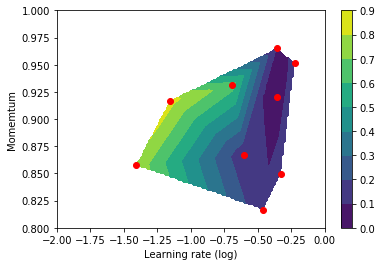

In [77]:
X, Y, Z = grid(lr_samples, mom_samples, np.array(acc_list))

plt.contourf(X, Y, Z)
plt.colorbar()
plt.scatter(lr_samples, mom_samples, c='r')

plt.xlim(*lr_r)
plt.ylim(*mom_r)
plt.xlabel('Learning rate (log)')
plt.ylabel('Momemtum')
plt.show()

**Grid search**

In [60]:
# Grid search
num = 3
lr_args = {'start': lr_r[0], 'stop': lr_r[1], 'num': num}
mom_args = {'start': mom_r[0], 'stop': mom_r[1], 'num': num}

lr_l, mom_l = np.meshgrid(np.logspace(**lr_args), np.linspace(**mom_args))
lr_l, mom_l = lr_l.flatten(), mom_l.flatten()
option_list =  np.array([lr_l, mom_l]).T

lr_samples = np.log10(lr_l)
mom_samples = mom_l

In [61]:
loss_list, acc_list = loss_acc(option_list)

Testing with: lr:0.01, momentum:0.8
Testing with: lr:0.1, momentum:0.8
Testing with: lr:1.0, momentum:0.8
Testing with: lr:0.01, momentum:0.9
Testing with: lr:0.1, momentum:0.9
Testing with: lr:1.0, momentum:0.9
Testing with: lr:0.01, momentum:1.0
Testing with: lr:0.1, momentum:1.0
Testing with: lr:1.0, momentum:1.0


In [62]:
print_winner(loss_list, acc_list)

Winner table:
0) [ 0.1  0.9]
    Loss: 0.52, Acc: 0.838
1) [ 0.1  1. ]
    Loss: 0.62, Acc: 0.829
2) [ 0.1  0.8]
    Loss: 0.54, Acc: 0.811
3) [ 0.01  0.9 ]
    Loss: 0.66, Acc: 0.805
4) [ 0.01  1.  ]
    Loss: 0.71, Acc: 0.742
5) [ 0.01  0.8 ]
    Loss: 0.89, Acc: 0.688
6) [ 1.  1.]
    Loss: 1.4e+01, Acc: 0.11
7) [ 1.   0.9]
    Loss: 1.4e+01, Acc: 0.107
8) [ 1.   0.8]
    Loss: 1.5e+01, Acc: 0.087


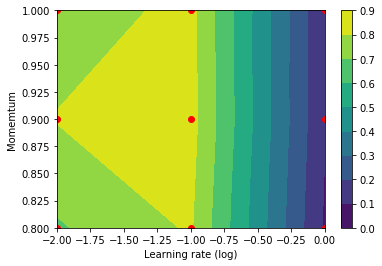

In [73]:
X, Y, Z = grid(lr_samples, mom_samples, np.array(acc_list))

plt.contourf(X, Y, Z)
plt.colorbar()
plt.scatter(lr_samples, mom_samples, c='r')

plt.xlim(*lr_r)
plt.ylim(*mom_r)
plt.xlabel('Learning rate (log)')
plt.ylabel('Momemtum')
plt.show()

**Extensive random search**

In [78]:
# Random search
samples = 100
lr_args = {'low': lr_r[0], 'high': lr_r[1], 'size': samples}
mom_args = {'low': mom_r[0], 'high': mom_r[1], 'size': samples}

lr_samples = np.random.uniform(**lr_args)
mom_samples =  np.random.uniform(**mom_args)
option_list =  np.array([10**lr_samples, mom_samples]).T
loss_list, acc_list = loss_acc(option_list, verbose=False)

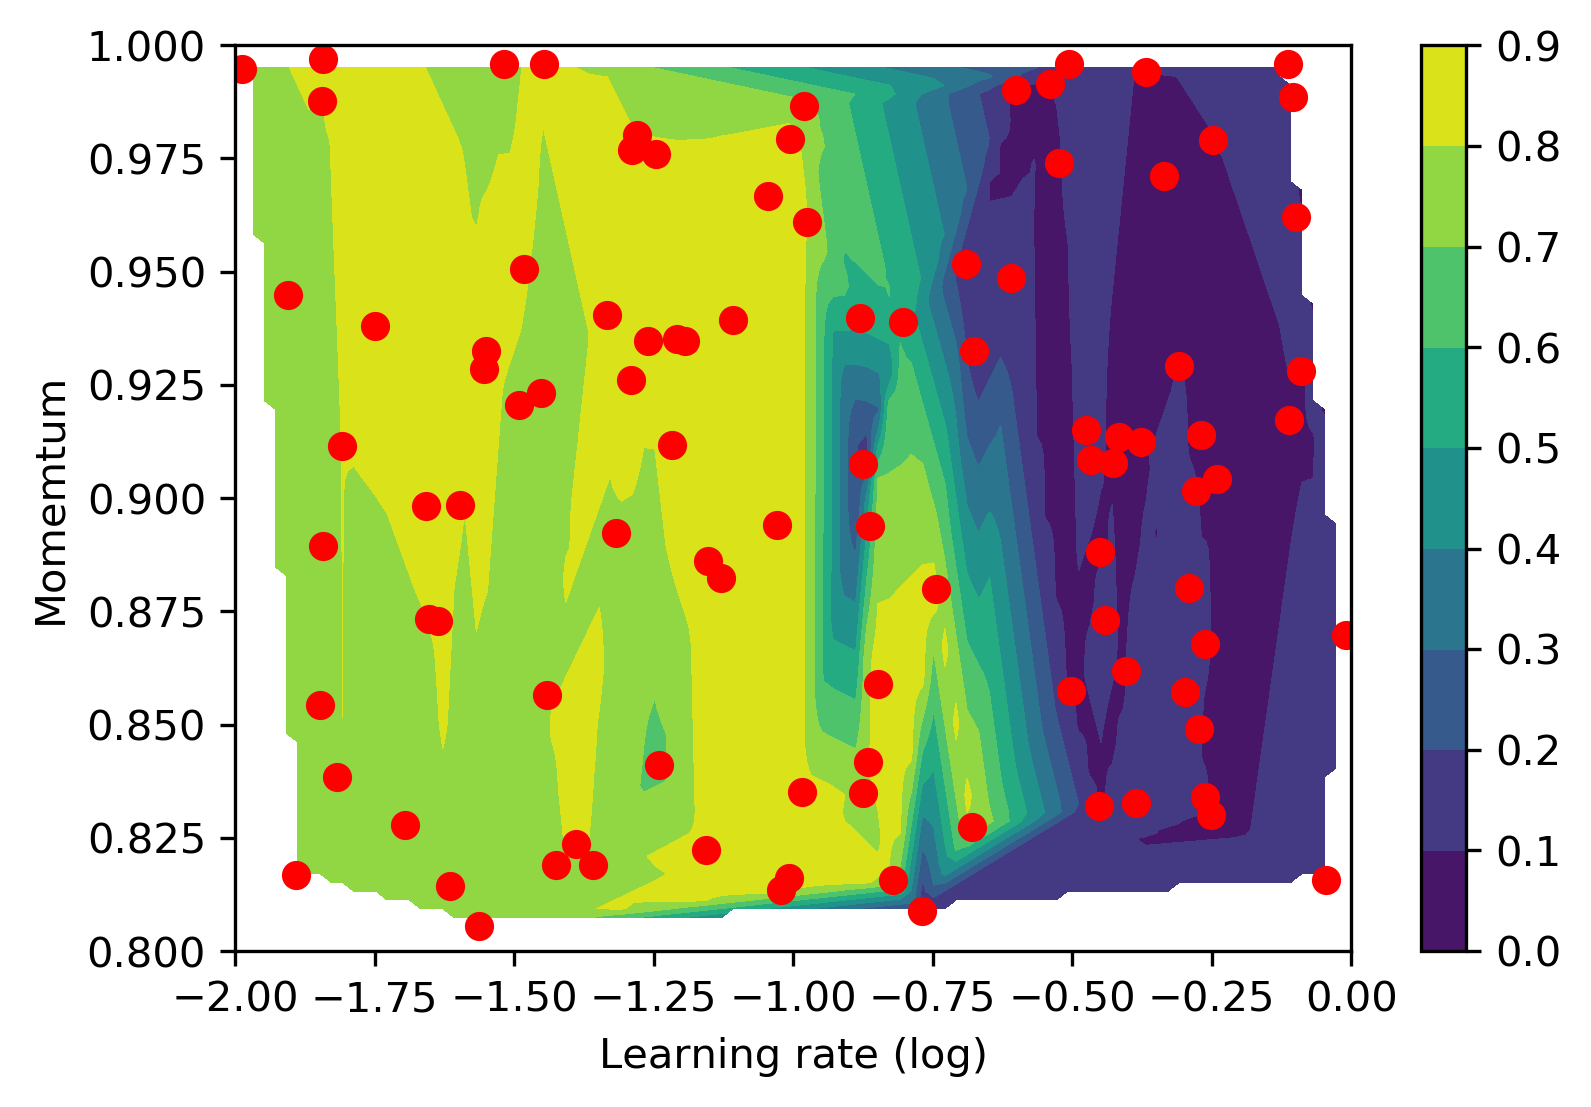

In [82]:
X, Y, Z = grid(lr_samples, mom_samples, np.array(acc_list))

ax = plt.contourf(X, Y, Z)
plt.scatter(lr_samples, mom_samples, c='r')

plt.colorbar(ax)
plt.xlim(*lr_r)
plt.ylim(*mom_r)
plt.xlabel('Learning rate (log)')
plt.ylabel('Momemtum')
plt.show()

**Extensive Grid search**

In [83]:
# Grid search
num = 10
lr_args = {'start': lr_r[0], 'stop': lr_r[1], 'num': num}
mom_args = {'start': mom_r[0], 'stop': mom_r[1], 'num': num}

lr_l, mom_l = np.meshgrid(np.logspace(**lr_args), np.linspace(**mom_args))
lr_l, mom_l = lr_l.flatten(), mom_l.flatten()
option_list =  np.array([lr_l, mom_l]).T

lr_samples = np.log10(lr_l)
mom_samples = mom_l
loss_list, acc_list = loss_acc(option_list, verbose=False)

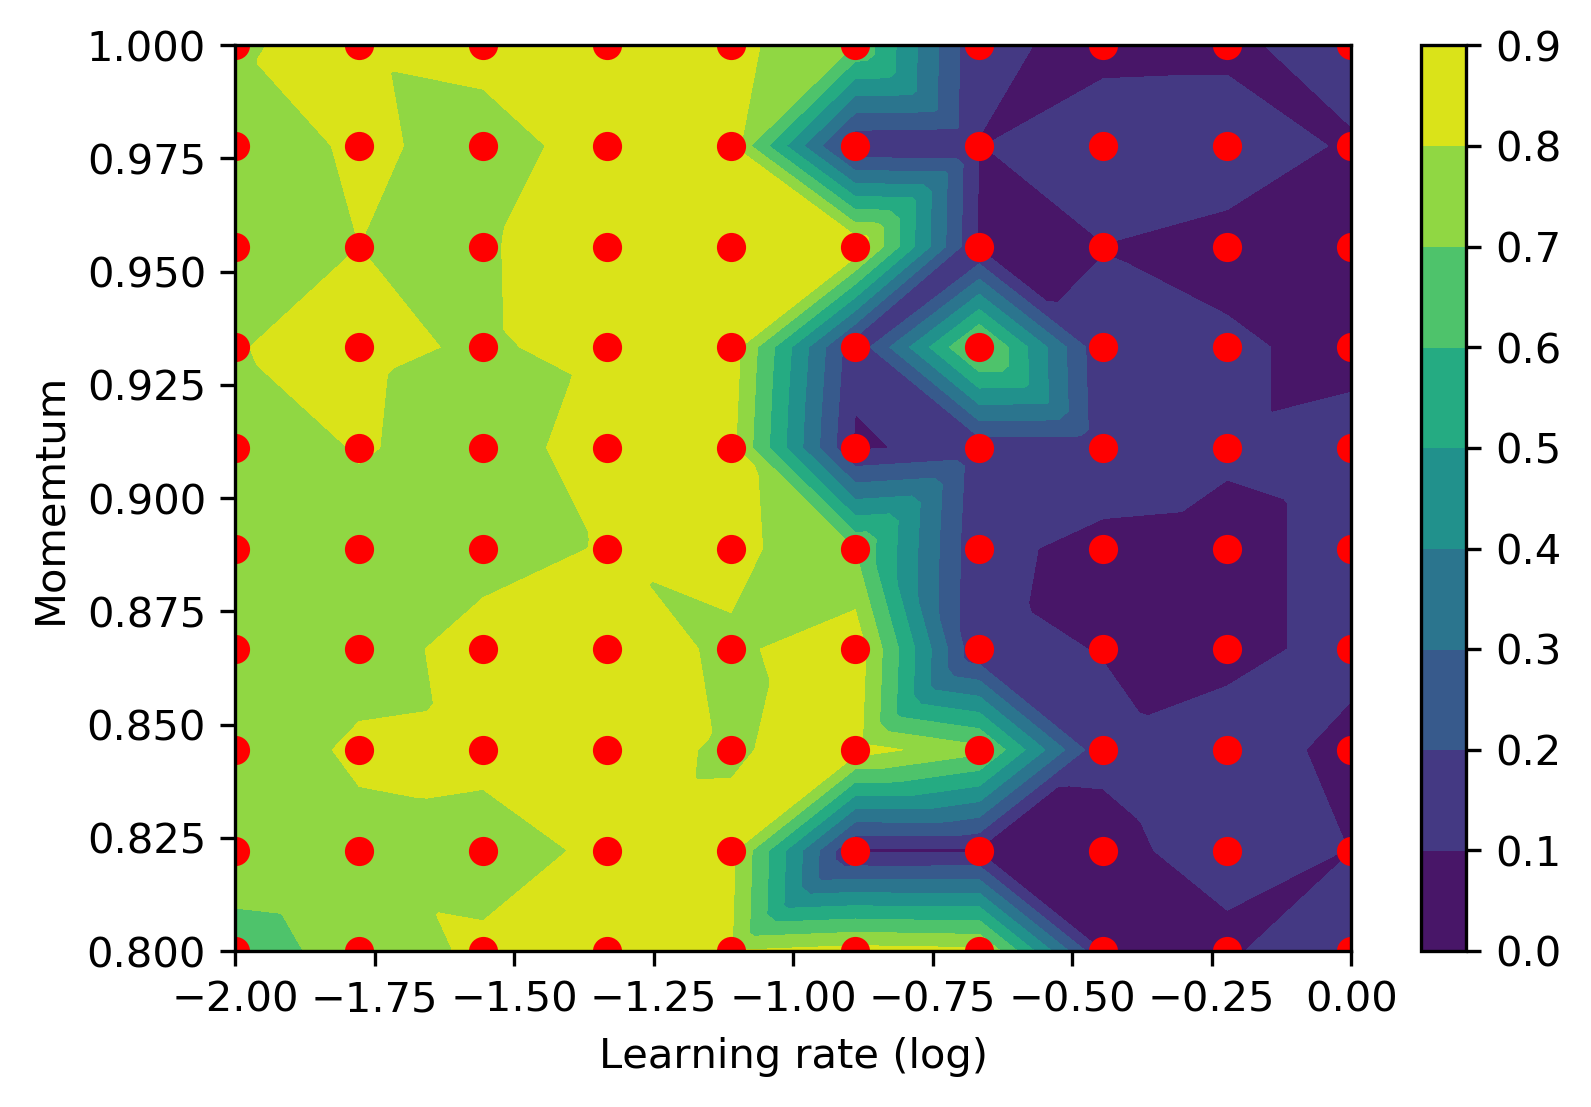

In [84]:
X, Y, Z = grid(lr_samples, mom_samples, np.array(acc_list))

plt.contourf(X, Y, Z)
plt.colorbar()
plt.scatter(lr_samples, mom_samples, c='r')

plt.xlim(*lr_r)
plt.ylim(*mom_r)
plt.xlabel('Learning rate (log)')
plt.ylabel('Momemtum')
plt.show()